#### Introduction

In this Jupyter notebook I will do some research about the VIX premium harvesting strategy that are explained in these two articles written by RobotJames:
- https://robotjames.com/posts/why-do-vix-futures-trade-at-a-different-price-to-the-vix-index/
- https://robotjames.com/posts/carrywhoring-with-vix-futures/

The strategy operates under the assumptions of the following stylized facts:

- The VIX index exhibits a high level of predictability, stemming from various reasons: 1) notable autocorrelation, 2) a lower limit around 9, 3) a tendency to rise when initially low, 4) a tendency to decline when initially high, and 5) a positive skewness in its distribution.
- VIX futures commonly command a premium in trading. This primarily arises due to the skewed distribution of future prices when the VIX is trading at a low point. This asymmetry prompts a preference for long positions among most traders, while short positions are favored by only a few participants. Consequently, a premium is logically attributed to VIX futures trading.
- Additionally, the VIX demonstrates a negative correlation with global risk. Hence, during periods of widespread stock declines, the VIX displays an upward trend.



Basis is the difference between VIX futures and index (premium + expectaciones)
comprobar que es autocorrelado

#### 0) Load libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.graphics.tsaplots import plot_acf

mpl.rcParams['figure.dpi']= 250

#### 00) Parameters

In [16]:
FROM_DATE   = '2022-01-01'
TO_DATE     = '2023-07-28'

#### 1) Load data and filter it
VIX index and futures data was obtained from https://www.cboe.com/tradable_products/vix/vix_historical_data/

This data is freely offered by the CBOE (Chicago Board Options Exchange).

In [17]:
dfVIXindex = pd.read_csv('data/VIX_History.csv')
dfVIXindex = dfVIXindex.set_index('DATE')
dfVIXindex.index = pd.to_datetime(dfVIXindex.index, format='%m/%d/%Y').strftime('%Y-%m-%d')

#### 2) Autocorrelation analysis of VIX index

Let's examine the stylized fact that postulates a strong autocorrelation within the VIX index.

Text(0.5, 1.0, 'Autocorrelation of VIX index\n From 2022-01-01 to 2023-07-28')

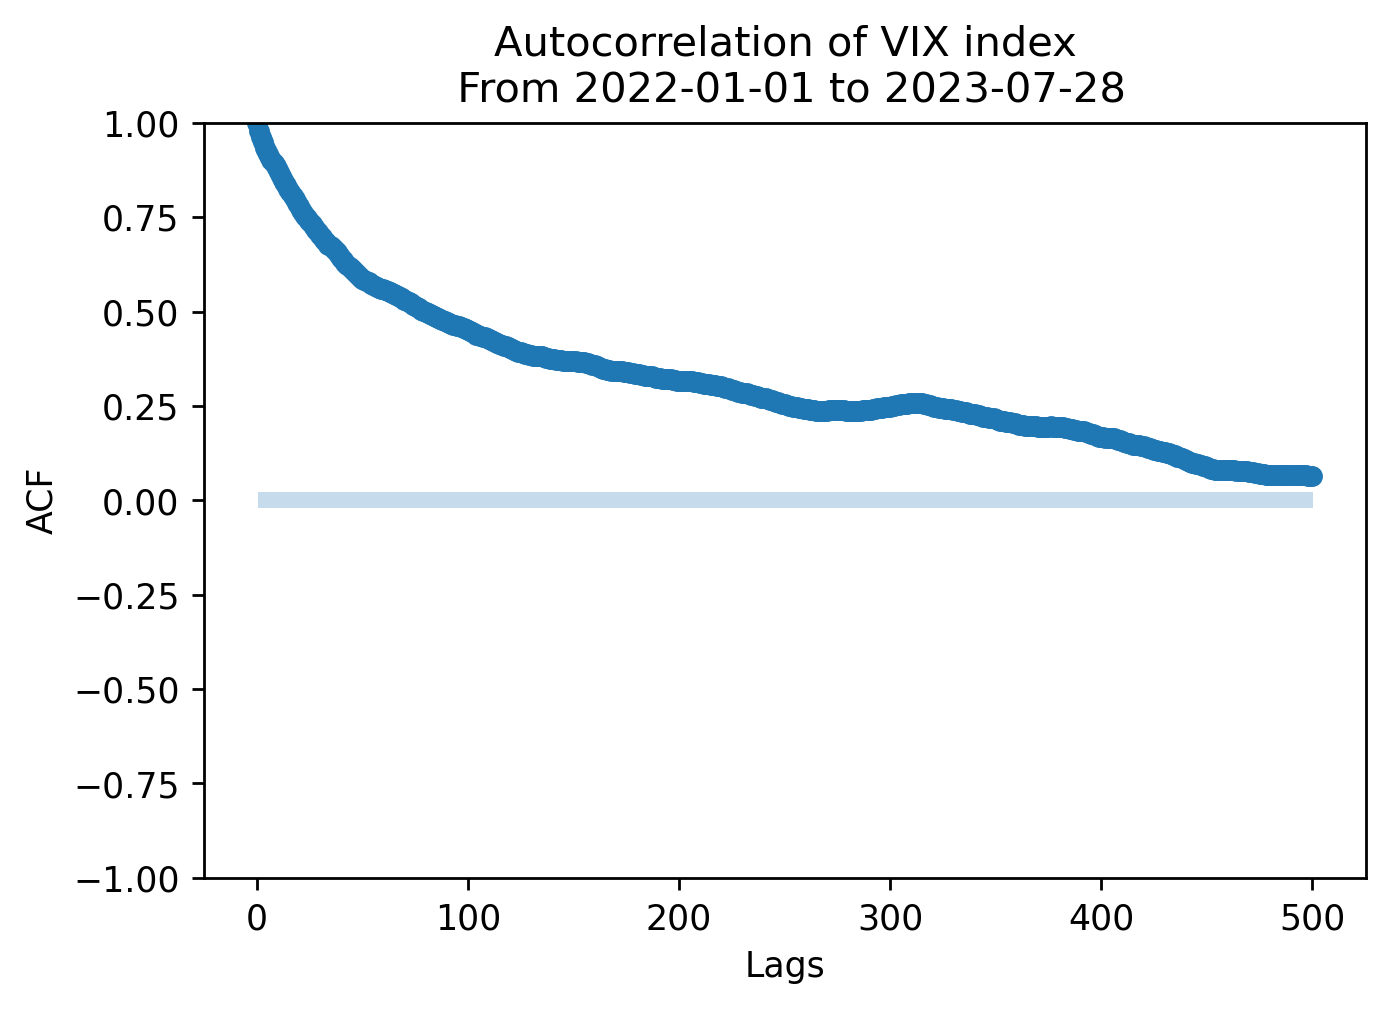

In [21]:
plot_acf(dfVIXindex['CLOSE'], lags=500, bartlett_confint = False, use_vlines = False)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation of VIX index\n From ' + FROM_DATE + ' to ' + TO_DATE)

The correlation decays very slowly, with correlations surpassing 0.5 observed even at lags of 80 days. This confirms the assertion that the VIX index is characterized by a marked degree of autocorrelation in its time-series data.